In [10]:
import numpy as np
from copy import copy
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import time
%matplotlib inline



def time_theirs(N=20,M=10000):
    # M =  number of samples
    # N =  number of permutations

    #generate synthetic SNP data array "x0"
    #which is a 2xM array generated such that SNPs will each be in hardy-weinberg eq.,
    #with a minor allele frequency of "p"
    p=0.55
    x0=np.random.rand(2,M)
    x0=(x0>(p**2)).astype(int)+(x0>(p**2+2*p*(1-p))).astype(int)
    
    #generate binary phenotype labels, where "p_f" have a value 0 (and 1-p_f have value 1)
    p_f=0.66
    p0=np.random.rand(M)
    p0=(p0>p_f).astype(int)
    pheno=copy(p0)
    
    #calculate un-permuted count table
    C0=np.zeros((2,3,3))
    for i in range(3):
        for j in range(3):
            for k in range(2):
                C0[k,i,j]=np.sum((x0[0]==i)&(x0[1]==j)&(pheno==k))
                
    ## START TIMING NAIVE PERMUTATION ##
    tic=time.clock()
    #initialize array to hold "N" 2x3x3 count tables
    C1=np.zeros((2,3,3,N))
    for n in range(N):
        #at each iteration, shuffle the phenotype labels
        np.random.shuffle(p0)
        for i in range(3):
            for j in range(3):
                for k in range(2):
                    #simply count and record how many of this combination exist given the shuffled phenotype label
                    C1[k,i,j,n]=np.sum((x0[0]==i)&(x0[1]==j)&(p0==k))
    dt=time.clock()-tic
    return dt

def time_ours(N=20,M=10000,C0=[]):
    # M =  number of samples
    # N =  number of permutations
    
    # if no count table is provided, generate one
    if C0==[]:
        #generates 2x3x3 count table where first dim is binary phenotype with frequency "f_p",
        # and dimensions 2/3 are SNPs in in hardy-weinberg eq.,
        #with a minor allele frequency of "p"
        #note that we generate the count table directly (which is equivalent but much faster)
        #whereas "time_theirs" has to generate the synthetic data first, since it needs it
        #for permutations. This does not factor into the timing as timing doesn't start until
        #after data is generated in each case.
        p=0.55
        f_p=0.66

        pv=np.array([[p**2,2*p*(1-p),(1-p)**2]])
        pv=pv*pv.T
        pv=pv[None,:,:]*np.array([f_p,1.0-f_p])[:,None,None]
        pv=pv.ravel()
        C0=np.random.multinomial(M,pv).reshape((2,3,3))
    ## START TIMING ##
    tic=time.clock()
    C0=np.stack([C0]*N,-1)
    # sum across first axis to get genotype counts in each
    nij=C0.sum(0).reshape(9,-1).astype(int)
    #nrem[k] is the remaining total genotype counts at the k'th (i,j)
    nrem=np.sum(nij,0)[None,:]-np.cumsum(nij,0)
    #n0 is the total number of zero labels
    n0=C0[0].sum(axis=(0,1)).ravel().astype(int)
    #n0p is the total number of zero labels left to be assigned in the permuted tables
    n0p=copy(n0)
    #initialize "Co" array to store results from our method
    Co=np.zeros(nij.shape)
    for k in range(nij.shape[0]):
        #draw new phenotype labels for each (i,j) from hypergeometric distribution
        Co[k][n0p!=0]=np.random.hypergeometric(nij[k][n0p!=0],nrem[k][n0p!=0],n0p[n0p!=0])
        #subtract the number of labels already assigned to get updated number remaining
        n0p=(n0-np.sum(Co,0)).astype(int)
    #reshape pheno=0 layer of each array back to 1x3x3
    Co=Co.reshape((1,3,3,N))
    #get value-1 labels by subtracting from value-0 labels from total at each (i,j)
    Co=np.vstack([Co,nij.reshape(1,3,3,N)-Co])
    dt=time.clock()-tic
    return dt


In [11]:
#fix the number of permutations N and calculate each approach over a range of M (number of individuals)
N=20
M2=np.logspace(2,8,100).astype(int)
MDT2=[]
nloops=100
#compute each value "nloops" times and take mean computation time afterwards
for n in tqdm(range(nloops)):
    dt2=[]
    #shuffle M2 to reduce systemic bias if computation slows/speeds due to external processes
    np.random.shuffle(M2)
    dt2k=[]
    for k,M in enumerate(M2):
        dt2k.append(time_ours(N=N,M=M))
    dt2k=np.array(dt2k)
    dt2.append(dt2k[np.argsort(M2)])
    MDT2.append(dt2)
M2=M2[np.argsort(M2)]
MDT2m=np.vstack(MDT2).mean(0)

M1=np.logspace(2,5,100).astype(int)
MDT1=[]
for n in tqdm(range(nloops)):
    dt1=[]
    #shuffle M1 to reduce systemic bias if computation slows/speeds due to external processes
    np.random.shuffle(M1)
    dt1k=[]
    for k,M in enumerate(M1):
        dt1k.append(time_theirs(N=N,M=M))
    dt1k=np.array(dt1k)
    dt1.append(dt1k[np.argsort(M1)])
    MDT1.append(dt1)
M1=M1[np.argsort(M1)]
MDT1m=np.vstack(MDT1).mean(0)

In [14]:
#fix the number of individuals M and calculate each approach over a range of N (number of permutations)

M=100000

N1=np.arange(10,100)
N2=np.logspace(1,5,100).astype(int)
DT1=[]
DT2=[]
nloops=10
#compute each value "nloops" times and take mean computation time afterwards
for n in tqdm(range(nloops)):
    dt1=[]
    for k,N in enumerate(N1):
        dt1.append(time_theirs(N=N,M=M))
    DT1.append(dt1)

    dt2=[]
    for k,N in enumerate(N2):
        dt2.append(time_ours(N=N,M=M))
    DT2.append(dt2)
DT1m=np.vstack(DT1).mean(0)
DT2m=np.vstack(DT2).mean(0)


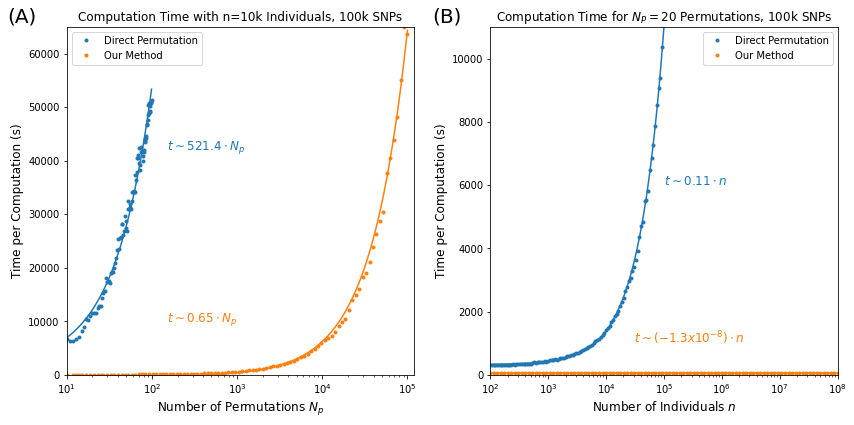

In [15]:
plt.figure(figsize=(12,6))

#scale all of the computation times by the total number of SNPs of interest: trivially, time scales linearly in
#number of SNPs
scale=1e5
DT1m_scale=DT1m*scale
DT2m_scale=DT2m*scale
MDT1m_scale=MDT1m*scale
MDT2m_scale=MDT2m*scale

### Plot varying number of permutations N ###
plt.subplot(1,2,1)
#fit a linear line to the time data
m1,b1=np.polyfit(N1,DT1m_scale,1)
m2,b2=np.polyfit(N2,DT2m_scale,1)

#plot both the data itself and the line fit
l1,=plt.plot(N1,DT1m_scale,'.',label='Direct Permutation')
l2,=plt.plot(N2,DT2m_scale,'.',label='Our Method')
plt.plot(N1,m1*N1+b1,c=l1.get_color())
plt.plot(N2,m2*N2+b2,c=l2.get_color())

plt.xscale('log')
plt.legend()

plt.title('Computation Time with n=10k Individuals, 100k SNPs')
plt.ylabel('Time per Computation (s)',fontsize=12)
plt.xlabel('Number of Permutations $N_p$',fontsize=12)

e1=int(np.floor(np.log10(m1)))
r1=m1/(10**e1)
plt.text(1.5e2,0.42*scale,'$t \sim {:0.1f}\cdot N_p$'.format(m1),c=l1.get_color(),fontsize=12)
e2=int(np.floor(np.log10(m2)))
r2=m2/(10**e2)
plt.text(1.5e2,0.1*scale,'$t \sim {:0.2f}\cdot N_p$'.format(m2,b2),c=l2.get_color(),fontsize=12)

plt.text(2,0.659*scale,'(A)',fontsize=20)
plt.xlim(10,1.2e5)
plt.ylim([-0.01,0.65*scale])

### Plot varying number of individuals M ###
plt.subplot(1,2,2)
#fit a linear line to the time data
m1,b1=np.polyfit(M1,MDT1m_scale,1)
m2,b2=np.polyfit(M2,MDT2m_scale,1)
#plot both the data itself and the line fit
l1,=plt.plot(M1,MDT1m_scale,'.',label='Direct Permutation')
l2,=plt.plot(M2,MDT2m_scale,'.',label='Our Method')
plt.plot(M1,m1*M1+b1,c=l1.get_color())
plt.plot(M2,m2*M2+b2,c=l2.get_color())

plt.xscale('log')
plt.legend()



plt.title('Computation Time for $N_P=20$ Permutations, 100k SNPs')
plt.ylabel('Time per Computation (s)',fontsize=12)
plt.xlabel('Number of Individuals $n$',fontsize=12)

e1=int(np.floor(np.log10(m1)))
r1=m1/(10**e1)
plt.text(1e5,0.06*scale,'$t \sim {:0.2f}\cdot n$'.format(m1,b1),c=l1.get_color(),fontsize=12)

e2=int(np.floor(np.log10(np.abs(m2))))
r2=m2/(10**e2)
plt.text(3e4,0.01*scale,'$t \sim ({:0.1f}x 10^{{{:}}})\cdot n$'.format(r2,e2,b2),c=l2.get_color(),fontsize=12)

plt.text(10,0.1115*scale,'(B)',fontsize=20)
plt.xlim(1e2,1e8)
plt.ylim([-0.001,0.11*scale])

plt.tight_layout()

#plt.savefig('computation_times.svg')
#plt.savefig('computation_times.png',dpi=200)